# Feature Extraction using Convolutional Neural Networks
[GitHub Tutorial:CIFAR 10 feature extraction using pretrained convolutional depp neural networks from keras library](https://github.com/rnoxy/cifar10-cnn/blob/master/Feature_extraction_using_keras.ipynb)

In [1]:
#Github code
network_names = [ 'incv3', 'resnet50', 'vgg16', 'vgg19' ]

print("Available networks = ", network_names)
cnnid = int( input("Please choose the CNN network [0-{n}]: ".format(n=len(network_names)-1)) )
selected_network = network_names[cnnid]
print("Selected network: ", selected_network)

Available networks =  ['incv3', 'resnet50', 'vgg16', 'vgg19']
Please choose the CNN network [0-3]: 3
Selected network:  vgg19


In [2]:
 pip install myutils

  Created wheel for myutils: filename=myutils-0.0.21-py3-none-any.whl size=1364 sha256=b0e2a10bed924a891a61c3f692d14ff5a8065b53b8c781e9c7564b7594c1f51c
  Stored in directory: /root/.cache/pip/wheels/8e/89/9f/ab7f23dcc9ba30d64a298bcfc29c4e7e9ec59110ddc69aac12
Successfully built myutils


In [3]:
#github
import time
import myutils
import numpy as np
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_v2_behavior()
from keras.layers import Input, Dense, AveragePooling2D, GlobalAveragePooling2D, Conv2D
from keras import backend as K

Instructions for updating:
non-resource variables are not supported in the long term


## Load CIFAR10 data

170508288/170498071 [==============================] - 5s 0us/step
(50000, 32, 32, 3) (50000,) (10000, 32, 32, 3) (10000,)


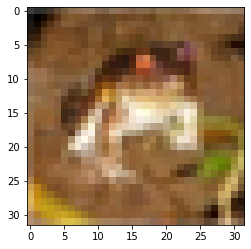

In [4]:
#github
from keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

n_training = X_train.shape[0]
n_testing = X_test.shape[0]

y_train = y_train.flatten()
y_test  = y_test.flatten()

print( X_train.shape, y_train.shape,  X_test.shape, y_test.shape )

from matplotlib import pyplot as plt
plt.imshow( X_train[0]  )
plt.show()

## Create model

In [5]:
#github
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet     import ResNet50
from keras.applications.vgg16        import VGG16
from keras.applications.vgg19        import VGG19

input_shape = {
    'incv3'   : (299,299,3),
    'resnet50': (224,224,3),
    'vgg16'   : (224,224,3),
    'vgg19'   : (224,224,3)
}[selected_network]

def create_model_incv3():
    tf_input = Input(shape=input_shape)
    model = InceptionV3(input_tensor=tf_input, weights='imagenet', include_top=False)
    output_pooled = AveragePooling2D((8, 8), strides=(8, 8))(model.output)
    return Model(model.input, output_pooled)

def create_model_resnet50():
    tf_input = Input(shape=input_shape)
    return ResNet50(input_tensor=tf_input, include_top=False)

def create_model_vgg16():
    tf_input = Input(shape=input_shape)
    model = VGG16(input_tensor=tf_input, include_top=False)
    output_pooled = AveragePooling2D((7, 7))(model.output)
    return Model(model.input, output_pooled )

def create_model_vgg19():
    tf_input = Input(shape=input_shape)
    model = VGG19(input_tensor=tf_input, include_top=False)
    convolutional_layer = Conv2D(100,1)(model.output)
    output_pooled = AveragePooling2D((7, 7))(convolutional_layer)
    return Model(model.input, output_pooled )

create_model = {
    'incv3'    : create_model_incv3,
    'resnet50' : create_model_resnet50,
    'vgg16'    : create_model_vgg16,
    'vgg19'    : create_model_vgg19
}[selected_network]

## Data generator for tensorflow

[Tensorflow 1 to 2](https://stackoverflow.com/questions/60966376/best-practice-to-write-code-compatible-to-both-tensorflow-1-and-2)

In [6]:
#github
# tensorflow placeholder for batch of images from CIFAR10 dataset
batch_of_images_placeholder = tf.placeholder("uint8", (None, 32, 32, 3))

batch_size = {
    'incv3'    : 16,
    'resnet50' : 16,
    'vgg16'    : 16,
    'vgg19'    : 16
}[selected_network]

# Inception default size is 299x299
tf_resize_op = tf.image.resize(batch_of_images_placeholder, (input_shape[:2]), method='bilinear')

In [7]:
#github
# data generator for tensorflow session
from keras.applications.inception_v3 import preprocess_input as incv3_preprocess_input
from keras.applications.resnet     import preprocess_input as resnet50_preprocess_input
from keras.applications.vgg16        import preprocess_input as vgg16_preprocess_input
from keras.applications.vgg19        import preprocess_input as vgg19_preprocess_input

preprocess_input = {
    'incv3'   : incv3_preprocess_input,
    'resnet50': resnet50_preprocess_input,
    'vgg16'   : vgg16_preprocess_input,
    'vgg19'   : vgg19_preprocess_input
}[selected_network]

def data_generator(sess,data,labels):
    def generator():
        start = 0
        end = start + batch_size
        n = data.shape[0]
        while True:
            batch_of_images_resized = sess.run(tf_resize_op, {batch_of_images_placeholder: data[start:end]})
            batch_of_images__preprocessed = preprocess_input(batch_of_images_resized)
            batch_of_labels = labels[start:end]
            start += batch_size
            end   += batch_size
            if start >= n:
                start = 0
                end = batch_size
            yield (batch_of_images__preprocessed, batch_of_labels)
    return generator

## Feature extraction

In [8]:
with tf.Session() as sess:
    # setting tensorflow session to Keras
    K.set_session(sess)
    # setting phase to training
    K.set_learning_phase(1)  # 0 - test,  1 - train

    model = create_model()

    data_train_gen = data_generator(sess, X_train, y_train)
    ftrs_training = model.predict_generator(data_train_gen(), n_training/batch_size, verbose=1)

    data_test_gen = data_generator(sess, X_test, y_test)
    ftrs_testing = model.predict_generator(data_test_gen(), n_testing/batch_size, verbose=1)

/usr/local/lib/python3.7/dist-packages/keras/backend.py:414: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


80150528/80134624 [==============================] - 1s 0us/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


In [9]:
#github
features_training = np.array( [ftrs_training[i].flatten() for i in range(n_training)] )
features_testing  = np.array( [ftrs_testing[i].flatten()  for i in range(n_testing )] )

#np.savez_compressed("features/CIFAR10_{}-keras_features.npz".format(selected_network),features_training=features_training,features_testing=features_testing,labels_training=y_train,labels_testing=y_test)

## Feature visualization

### Feature analysis (using PCA)

In [10]:
#github
import numpy as np
import myutils

#data = np.load("features/CIFAR10_{}-keras_features.npz".format(selected_network))

X_training = features_training
y_training = y_train

X_testing = features_testing
y_testing = y_test

# data_training, data_testing = myutils.load_CIFAR_dataset(shuffle=False)
# assert( (np.array( [data_training[i][1] for i in range(len(data_training))] ) == y_training).all() )
# assert( (np.array( [data_testing[i][1] for i in range(len(data_testing))] ) == y_testing).all() )
print( 'X_training size = {}'.format(X_training.shape))

X_training size = (50000, 100)


# File export

In [11]:
import pandas as pd
y_training_1=np.reshape(y_training,(50000,1))
y_testing_1=np.reshape(y_testing,(10000,1))
data_train= np.concatenate((X_training,y_training_1),axis=1)
data_test= np.concatenate((X_testing,y_testing_1),axis=1)
df_train=pd.DataFrame(data=data_train)
df_test=pd.DataFrame(data=data_test)

In [12]:
df_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
0,-1.573607,0.927247,3.882936,-1.763740,-2.963583,0.709206,-0.914935,-0.194965,-4.679477,7.683812,-1.205905,5.309304,-2.349698,-3.395091,3.278696,-1.317629,4.853652,-3.115184,-0.456200,-1.567518,-3.034143,4.722073,-0.621468,-0.097883,-3.302875,1.734647,1.388245,-0.078671,-4.285583,6.201243,-7.776204,3.408791,6.350056,-0.259288,-0.933201,-0.746448,2.350238,4.293361,1.564657,0.832683,...,2.595668,1.972341,-3.396488,-5.707074,-0.634112,-0.468663,-0.127652,0.184657,0.357079,1.574442,-2.783144,-2.344200,0.322870,-2.400333,1.466477,3.188078,-5.657234,4.897846,3.072559,6.467072,2.082528,1.178624,-0.307005,-0.345819,1.998130,4.529057,1.440097,-0.304466,4.421744,-2.850635,-2.076103,-6.156373,-4.370422,-4.771835,-3.041949,10.769374,0.235837,5.345856,-1.356994,6.0
1,0.910514,1.448640,1.866469,-0.915723,-4.453482,4.193243,3.727407,-2.673490,-1.996203,10.473466,-1.100927,6.685602,-4.148135,-3.917332,3.483708,4.672894,5.976211,-0.788409,-4.408353,0.592914,-7.074314,7.752588,-0.663798,-1.454667,-2.931700,1.074268,5.072372,-0.603213,-4.884461,1.515543,-7.995411,6.948911,3.053638,4.754682,-2.804942,2.602504,2.689762,3.106359,0.219236,1.089025,...,1.314294,1.323601,-7.235801,-4.902535,-2.228088,0.563099,1.744807,4.438805,2.036260,5.567071,1.903112,-3.644002,-6.172979,-1.202025,3.289009,0.836735,-4.944955,4.660869,4.758077,7.347364,-3.697713,-3.596338,-2.577512,0.344403,-1.124604,6.437228,3.666871,-5.670012,3.426779,0.568715,2.784510,-3.304834,-2.211906,-7.783305,-6.085986,3.535079,1.801697,5.017786,2.802118,9.0
2,1.213342,1.232067,0.209595,3.138318,2.665217,3.163791,-2.964055,-0.976173,2.797888,5.510724,-2.880878,3.233924,0.913445,0.020271,5.285484,-1.007480,1.639018,-1.755431,-2.882352,1.615728,0.743106,6.372139,-1.592780,-3.630688,-2.400655,4.075251,4.543087,-3.703797,-6.081393,-0.635411,-3.877115,5.008809,0.108580,2.360045,0.576069,-2.089370,3.626319,1.379880,5.337899,3.051415,...,1.975295,-0.249951,0.807973,-1.406019,0.133440,0.091667,0.486038,-0.915347,3.556045,1.041341,5.342354,-3.087600,-0.557512,-0.176919,4.636138,1.322761,-6.278999,3.179954,2.392751,2.971199,-0.474839,-2.165833,-1.516671,1.835044,-3.696179,0.754159,-1.986294,-2.612177,-1.426669,-1.108011,1.355495,-1.484263,0.883385,-2.248993,-2.348715,3.987577,-0.735797,2.553546,-1.872256,9.0
3,-2.062210,2.069041,-0.471739,0.819201,4.508037,-0.964389,-3.005833,0.330967,2.984250,4.584993,-2.481864,5.186476,0.148385,2.529959,3.684728,-3.346717,2.163612,-0.730011,0.609235,1.273864,-1.774887,1.706275,2.289570,0.977979,-2.799877,0.727345,-1.002385,-0.585270,-4.443184,2.743007,-4.195072,-0.265255,2.844642,0.760899,0.216458,-4.354957,-0.275593,2.989575,0.976224,0.576068,...,-1.507122,1.037501,-0.617782,-1.348163,1.331473,-0.781452,1.517437,1.068402,1.208080,3.793570,0.322455,-2.218975,-0.483031,-2.048893,1.179686,0.608225,-2.741886,2.455855,-0.180210,4.402599,0.611457,0.702521,0.342015,1.135947,-0.624904,2.148793,-4.182907,1.083731,2.147695,0.698507,1.167371,-4.369234,-1.436927,-3.565094,-0.715085,3.189633,-1.795509,3.185385,-1.195114,4.0
4,-1.010124,1.509578,1.141842,5.242296,4.468510,3.275473,-1.922809,3.020145,0.803726,10.687176,-6.708273,2.242326,0.274802,0.481986,3.687186,-2.629404,8.085792,-1.810043,-4.364555,-1.406932,-0.588401,1.359818,2.048186,1.366072,-1.952015,7.440148,5.915332,1.187908,-8.108755,4.642499,-8.158726,10.634002,-1.598437,1.825194,-0.399356,0.351444,4.333573,4.517610,2.634079,3.562856,...,-0.585929,1.849559,-0.378403,-4.978768,0.073706,-2.890968,-0.608438,-2.048084,0.912727,0.783068,2.719896,-2.668716,-1.880873,2.989464,7.841629,-0.439689,-5.411270,6.557738,1.135069,3.456826,-3.554777,-2.248702,0.434556,5.615566,0.400639,1.574355,1.258807,-3.755023,-0.433409,-3.736035,-0.040332,1.420970,-2.971931,-2.257771,-4.758689,4.893542,-2.092911,5.

In [13]:
df_train_final=df_train.rename({100:'Class Label'},axis=1)
df_train_final

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,Class Label
0,-1.573607,0.927247,3.882936,-1.763740,-2.963583,0.709206,-0.914935,-0.194965,-4.679477,7.683812,-1.205905,5.309304,-2.349698,-3.395091,3.278696,-1.317629,4.853652,-3.115184,-0.456200,-1.567518,-3.034143,4.722073,-0.621468,-0.097883,-3.302875,1.734647,1.388245,-0.078671,-4.285583,6.201243,-7.776204,3.408791,6.350056,-0.259288,-0.933201,-0.746448,2.350238,4.293361,1.564657,0.832683,...,2.595668,1.972341,-3.396488,-5.707074,-0.634112,-0.468663,-0.127652,0.184657,0.357079,1.574442,-2.783144,-2.344200,0.322870,-2.400333,1.466477,3.188078,-5.657234,4.897846,3.072559,6.467072,2.082528,1.178624,-0.307005,-0.345819,1.998130,4.529057,1.440097,-0.304466,4.421744,-2.850635,-2.076103,-6.156373,-4.370422,-4.771835,-3.041949,10.769374,0.235837,5.345856,-1.356994,6.0
1,0.910514,1.448640,1.866469,-0.915723,-4.453482,4.193243,3.727407,-2.673490,-1.996203,10.473466,-1.100927,6.685602,-4.148135,-3.917332,3.483708,4.672894,5.976211,-0.788409,-4.408353,0.592914,-7.074314,7.752588,-0.663798,-1.454667,-2.931700,1.074268,5.072372,-0.603213,-4.884461,1.515543,-7.995411,6.948911,3.053638,4.754682,-2.804942,2.602504,2.689762,3.106359,0.219236,1.089025,...,1.314294,1.323601,-7.235801,-4.902535,-2.228088,0.563099,1.744807,4.438805,2.036260,5.567071,1.903112,-3.644002,-6.172979,-1.202025,3.289009,0.836735,-4.944955,4.660869,4.758077,7.347364,-3.697713,-3.596338,-2.577512,0.344403,-1.124604,6.437228,3.666871,-5.670012,3.426779,0.568715,2.784510,-3.304834,-2.211906,-7.783305,-6.085986,3.535079,1.801697,5.017786,2.802118,9.0
2,1.213342,1.232067,0.209595,3.138318,2.665217,3.163791,-2.964055,-0.976173,2.797888,5.510724,-2.880878,3.233924,0.913445,0.020271,5.285484,-1.007480,1.639018,-1.755431,-2.882352,1.615728,0.743106,6.372139,-1.592780,-3.630688,-2.400655,4.075251,4.543087,-3.703797,-6.081393,-0.635411,-3.877115,5.008809,0.108580,2.360045,0.576069,-2.089370,3.626319,1.379880,5.337899,3.051415,...,1.975295,-0.249951,0.807973,-1.406019,0.133440,0.091667,0.486038,-0.915347,3.556045,1.041341,5.342354,-3.087600,-0.557512,-0.176919,4.636138,1.322761,-6.278999,3.179954,2.392751,2.971199,-0.474839,-2.165833,-1.516671,1.835044,-3.696179,0.754159,-1.986294,-2.612177,-1.426669,-1.108011,1.355495,-1.484263,0.883385,-2.248993,-2.348715,3.987577,-0.735797,2.553546,-1.872256,9.0
3,-2.062210,2.069041,-0.471739,0.819201,4.508037,-0.964389,-3.005833,0.330967,2.984250,4.584993,-2.481864,5.186476,0.148385,2.529959,3.684728,-3.346717,2.163612,-0.730011,0.609235,1.273864,-1.774887,1.706275,2.289570,0.977979,-2.799877,0.727345,-1.002385,-0.585270,-4.443184,2.743007,-4.195072,-0.265255,2.844642,0.760899,0.216458,-4.354957,-0.275593,2.989575,0.976224,0.576068,...,-1.507122,1.037501,-0.617782,-1.348163,1.331473,-0.781452,1.517437,1.068402,1.208080,3.793570,0.322455,-2.218975,-0.483031,-2.048893,1.179686,0.608225,-2.741886,2.455855,-0.180210,4.402599,0.611457,0.702521,0.342015,1.135947,-0.624904,2.148793,-4.182907,1.083731,2.147695,0.698507,1.167371,-4.369234,-1.436927,-3.565094,-0.715085,3.189633,-1.795509,3.185385,-1.195114,4.0
4,-1.010124,1.509578,1.141842,5.242296,4.468510,3.275473,-1.922809,3.020145,0.803726,10.687176,-6.708273,2.242326,0.274802,0.481986,3.687186,-2.629404,8.085792,-1.810043,-4.364555,-1.406932,-0.588401,1.359818,2.048186,1.366072,-1.952015,7.440148,5.915332,1.187908,-8.108755,4.642499,-8.158726,10.634002,-1.598437,1.825194,-0.399356,0.351444,4.333573,4.517610,2.634079,3.562856,...,-0.585929,1.849559,-0.378403,-4.978768,0.073706,-2.890968,-0.608438,-2.048084,0.912727,0.783068,2.719896,-2.668716,-1.880873,2.989464,7.841629,-0.439689,-5.411270,6.557738,1.135069,3.456826,-3.554777,-2.248702,0.434556,5.615566,0.400639,1.574355,1.258807,-3.755023,-0.433409,-3.736035,-0.040332,1.420970,-2.971931,-2.257771,-4.758689,4.893542,-2.0

In [14]:
df_test

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
0,-0.406891,2.518248,1.078850,0.542428,-1.991698,3.393651,-2.000609,1.459428,0.544127,8.005242,-1.053054,1.261404,-1.715821,-2.230837,1.391083,-1.127163,3.072299,-0.418020,-0.354380,-1.358149,-6.106869,5.170712,1.637093,0.989581,-4.579391,4.151536,2.914657,-4.002250,-9.515040,6.559072,-6.927586,10.398522,2.413292,-0.649714,0.033558,0.377107,2.334207,5.854296,-0.576425,1.199457,...,2.135411,-3.675972,-5.366721,-3.896145,-6.127431,1.810994,4.798275,4.335485,-0.616001,2.929961,-4.283516,-7.935171,-0.234127,-4.007546,3.366185,0.380584,-6.941287,4.937849,-0.920438,2.888647,-0.012701,-0.251181,-1.400726,-4.021502,-0.710572,1.162452,6.105257,-5.287781,7.635350,-6.115590,-2.456039,-3.918902,-0.854659,-0.920625,-6.272398,12.150599,-3.211717,4.291994,-1.800023,3.0
1,2.840969,0.343795,0.027460,1.814588,0.953517,5.074302,0.924205,-2.887625,2.180433,4.635614,-3.765052,1.546453,-1.905381,0.140657,2.288342,3.412723,3.999427,-1.114678,-2.548643,0.523662,-3.724485,8.159208,1.261084,-2.970985,-1.459229,-2.269148,3.899112,2.709216,-7.605333,4.085075,-7.186528,7.052611,-2.022627,4.907767,-0.580499,-2.429589,5.853577,2.985985,1.166809,3.843198,...,0.754489,2.196117,-3.049058,-2.216875,0.112952,-4.198903,-1.322584,0.739872,4.374454,-0.480405,0.167508,-3.313345,-4.940435,2.656987,2.479486,-2.370343,-8.086930,5.775332,1.605102,4.436729,-0.291768,-4.596623,-1.611078,-3.506652,-3.746497,2.383273,3.284377,-2.596555,2.792565,-2.718897,-1.838858,-0.961226,-0.228185,-3.908548,-3.032962,3.837305,0.023137,5.692143,-1.926771,8.0
2,4.493119,0.410996,2.371259,1.013259,-4.057048,6.923604,1.012868,-0.229702,-0.866060,6.087259,-1.329655,2.703104,-1.397910,-2.640235,3.519978,1.091586,3.706748,0.966362,-4.892934,3.873962,-3.442985,9.049298,-0.940015,2.707744,-0.287437,2.193125,2.670566,0.510324,-7.730081,3.849621,-7.835318,1.970378,-1.512367,0.293690,-1.118297,-1.335875,-0.515085,3.282062,2.846823,2.589786,...,0.014425,2.886383,-4.532232,-2.566256,-1.940717,-2.210607,0.968144,4.225369,-0.393876,2.760939,-1.637086,-0.879629,-4.575049,-1.036365,4.646371,-2.705232,-5.792249,5.355971,-0.680654,3.325286,0.044058,-4.738656,0.743313,0.112895,-2.424680,2.756547,1.213395,-2.711294,2.185699,-1.886541,-2.217638,-1.704095,-1.250339,-5.571286,-5.933181,3.077938,-1.398100,3.688967,-1.630913,8.0
3,3.223652,1.491172,1.007674,-2.064836,-2.347337,0.038917,0.244371,-1.236836,0.512209,1.670135,1.507870,0.072475,1.938948,-1.474640,3.883215,2.277646,-0.723913,0.580420,-0.059560,-1.053529,-0.954800,4.039500,3.146638,1.449917,-2.659253,-2.921669,4.237142,3.001574,-2.436026,2.735623,-5.809900,1.894330,0.175979,2.884694,-2.220162,-3.457301,4.351336,-1.385360,1.918821,1.958940,...,-0.104747,-0.485440,-5.642671,-3.319880,1.685929,-1.887840,-4.885099,-0.947484,3.609770,1.231192,0.324470,-0.644404,0.177119,-0.287952,2.441458,-2.469265,-5.559037,2.931944,2.106593,2.216967,0.776722,-4.525781,2.644305,0.826037,0.253635,-0.434839,-0.398908,-2.057865,2.891492,-1.127649,-1.020960,-4.625875,2.174134,-1.645248,-0.435909,3.004525,0.849615,4.051802,-2.424884,0.0
4,-3.718518,5.119709,-0.553372,-1.777166,1.834947,-0.423276,1.430342,-0.556790,0.415500,1.908716,-2.972072,2.834928,-0.571710,0.854396,-2.849604,-2.777520,3.264365,1.142753,-2.909496,0.502205,-3.702855,4.623733,2.091056,-4.018740,-2.731803,0.745778,0.314773,0.952001,-4.458779,1.431312,-0.315957,1.473915,-0.752777,0.330628,-2.944594,-5.183078,1.749751,3.487346,-0.783965,1.865202,...,-0.138201,1.438813,-3.336251,-1.434738,1.259228,1.674026,1.834432,1.286223,3.421028,0.955940,-1.152770,-2.447772,0.122699,0.223356,2.861704,-0.733577,-6.294907,0.771785,0.871340,2.742333,-0.987805,0.708541,-1.346746,0.758257,-4.535367,-0.077944,1.772932,-1.241025,2.470007,-2.378195,-1.289669,-4.775533,-4.805315,-3.998765,-3.282487,0.14561

In [15]:
df_test_final=df_test.rename({100:'Class Label'},axis=1)
df_test_final

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,Class Label
0,-0.406891,2.518248,1.078850,0.542428,-1.991698,3.393651,-2.000609,1.459428,0.544127,8.005242,-1.053054,1.261404,-1.715821,-2.230837,1.391083,-1.127163,3.072299,-0.418020,-0.354380,-1.358149,-6.106869,5.170712,1.637093,0.989581,-4.579391,4.151536,2.914657,-4.002250,-9.515040,6.559072,-6.927586,10.398522,2.413292,-0.649714,0.033558,0.377107,2.334207,5.854296,-0.576425,1.199457,...,2.135411,-3.675972,-5.366721,-3.896145,-6.127431,1.810994,4.798275,4.335485,-0.616001,2.929961,-4.283516,-7.935171,-0.234127,-4.007546,3.366185,0.380584,-6.941287,4.937849,-0.920438,2.888647,-0.012701,-0.251181,-1.400726,-4.021502,-0.710572,1.162452,6.105257,-5.287781,7.635350,-6.115590,-2.456039,-3.918902,-0.854659,-0.920625,-6.272398,12.150599,-3.211717,4.291994,-1.800023,3.0
1,2.840969,0.343795,0.027460,1.814588,0.953517,5.074302,0.924205,-2.887625,2.180433,4.635614,-3.765052,1.546453,-1.905381,0.140657,2.288342,3.412723,3.999427,-1.114678,-2.548643,0.523662,-3.724485,8.159208,1.261084,-2.970985,-1.459229,-2.269148,3.899112,2.709216,-7.605333,4.085075,-7.186528,7.052611,-2.022627,4.907767,-0.580499,-2.429589,5.853577,2.985985,1.166809,3.843198,...,0.754489,2.196117,-3.049058,-2.216875,0.112952,-4.198903,-1.322584,0.739872,4.374454,-0.480405,0.167508,-3.313345,-4.940435,2.656987,2.479486,-2.370343,-8.086930,5.775332,1.605102,4.436729,-0.291768,-4.596623,-1.611078,-3.506652,-3.746497,2.383273,3.284377,-2.596555,2.792565,-2.718897,-1.838858,-0.961226,-0.228185,-3.908548,-3.032962,3.837305,0.023137,5.692143,-1.926771,8.0
2,4.493119,0.410996,2.371259,1.013259,-4.057048,6.923604,1.012868,-0.229702,-0.866060,6.087259,-1.329655,2.703104,-1.397910,-2.640235,3.519978,1.091586,3.706748,0.966362,-4.892934,3.873962,-3.442985,9.049298,-0.940015,2.707744,-0.287437,2.193125,2.670566,0.510324,-7.730081,3.849621,-7.835318,1.970378,-1.512367,0.293690,-1.118297,-1.335875,-0.515085,3.282062,2.846823,2.589786,...,0.014425,2.886383,-4.532232,-2.566256,-1.940717,-2.210607,0.968144,4.225369,-0.393876,2.760939,-1.637086,-0.879629,-4.575049,-1.036365,4.646371,-2.705232,-5.792249,5.355971,-0.680654,3.325286,0.044058,-4.738656,0.743313,0.112895,-2.424680,2.756547,1.213395,-2.711294,2.185699,-1.886541,-2.217638,-1.704095,-1.250339,-5.571286,-5.933181,3.077938,-1.398100,3.688967,-1.630913,8.0
3,3.223652,1.491172,1.007674,-2.064836,-2.347337,0.038917,0.244371,-1.236836,0.512209,1.670135,1.507870,0.072475,1.938948,-1.474640,3.883215,2.277646,-0.723913,0.580420,-0.059560,-1.053529,-0.954800,4.039500,3.146638,1.449917,-2.659253,-2.921669,4.237142,3.001574,-2.436026,2.735623,-5.809900,1.894330,0.175979,2.884694,-2.220162,-3.457301,4.351336,-1.385360,1.918821,1.958940,...,-0.104747,-0.485440,-5.642671,-3.319880,1.685929,-1.887840,-4.885099,-0.947484,3.609770,1.231192,0.324470,-0.644404,0.177119,-0.287952,2.441458,-2.469265,-5.559037,2.931944,2.106593,2.216967,0.776722,-4.525781,2.644305,0.826037,0.253635,-0.434839,-0.398908,-2.057865,2.891492,-1.127649,-1.020960,-4.625875,2.174134,-1.645248,-0.435909,3.004525,0.849615,4.051802,-2.424884,0.0
4,-3.718518,5.119709,-0.553372,-1.777166,1.834947,-0.423276,1.430342,-0.556790,0.415500,1.908716,-2.972072,2.834928,-0.571710,0.854396,-2.849604,-2.777520,3.264365,1.142753,-2.909496,0.502205,-3.702855,4.623733,2.091056,-4.018740,-2.731803,0.745778,0.314773,0.952001,-4.458779,1.431312,-0.315957,1.473915,-0.752777,0.330628,-2.944594,-5.183078,1.749751,3.487346,-0.783965,1.865202,...,-0.138201,1.438813,-3.336251,-1.434738,1.259228,1.674026,1.834432,1.286223,3.421028,0.955940,-1.152770,-2.447772,0.122699,0.223356,2.861704,-0.733577,-6.294907,0.771785,0.871340,2.742333,-0.987805,0.708541,-1.346746,0.758257,-4.535367,-0.077944,1.772932,-1.241025,2.470007,-2.378195,-1.289669,-4.775533,-4.805315,-3.998765,-3.282487

In [16]:
df_train_final.to_csv("TrainingDataCifar10Vgg19Size100.csv")

In [17]:
df_test_final.to_csv("TestingDataCifar10Vgg19Size100.csv")

# Classifier

In [18]:
#github
X = X_training

In [19]:
from sklearn.preprocessing import LabelBinarizer
#custom code
Y_train=LabelBinarizer().fit_transform(y_training)
Y_test=LabelBinarizer().fit_transform(y_testing)

In [20]:
from sklearn.neural_network import MLPClassifier
model=MLPClassifier()

In [21]:
#Please see the following website for reference
#https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

import numpy as np

# Number of hidden layers for the neural network
hidden_layer_sizes = [(20,),(10,10),(7,7,6),(5,5,5,5),(4,4,4,4,4)]

# activation function for neural network
#x=(a1)x1+(a2)x2+(a3)x3+....(an)(xn) 
#identity: f(x)=x
# logistic: f(x)=
# tanh:
# relu:
activation = ['logistic','tanh','relu']

# Maximum number of levels in tree
solver = ['lbfgs','sgd','adam']

# Minimum number of samples required to split a node
alpha = [0.0005, 0.001,0.005]

# Method of selecting samples for training each tree
learning_rate = ['constant', 'invscaling','adaptive']

# Number of features to consider at every split
power_t = [0.25, 0.5,0.75]

# Maximum number of levels in tree
max_iter = [100,200,300]

# Method of selecting samples for training each tree
tol = [1e-5,1e-4,1e-3]

# Minimum number of samples required to split a node
n_iter_no_change = [10, 50, 100]


# Create the random grid
random_grid = {'hidden_layer_sizes': hidden_layer_sizes,
               'activation': activation,
               'solver': solver,
               'alpha': alpha,
               'learning_rate': learning_rate,
               'power_t': power_t,
               'max_iter': max_iter,
               'tol': tol,
               'n_iter_no_change': n_iter_no_change}
print(random_grid)

{'hidden_layer_sizes': [(20,), (10, 10), (7, 7, 6), (5, 5, 5, 5), (4, 4, 4, 4, 4)], 'activation': ['logistic', 'tanh', 'relu'], 'solver': ['lbfgs', 'sgd', 'adam'], 'alpha': [0.0005, 0.001, 0.005], 'learning_rate': ['constant', 'invscaling', 'adaptive'], 'power_t': [0.25, 0.5, 0.75], 'max_iter': [100, 200, 300], 'tol': [1e-05, 0.0001, 0.001], 'n_iter_no_change': [10, 50, 100]}


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
model_random= RandomizedSearchCV(estimator=model,param_distributions= random_grid, n_iter=100, cv = 3, verbose=2, n_jobs=-1)

In [ ]:
model_random.fit(X,Y_train)
model_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'activation': 'relu',
 'alpha': 0.0005,
 'hidden_layer_sizes': (20,),
 'learning_rate': 'adaptive',
 'max_iter': 300,
 'n_iter_no_change': 100,
 'power_t': 0.75,
 'solver': 'adam',
 'tol': 0.001}

In [22]:
from sklearn.model_selection import GridSearchCV

# Create the random grid
param_grid = {
 'activation': ['relu'],
 'alpha': [0.0005,0.001],
 'hidden_layer_sizes': [(20,),(10, 10)],
 'learning_rate': ['adaptive','constant','invscaling'],
 'max_iter': [200,300],
 'n_iter_no_change': [10,100],
 'power_t': [0.25,0.5,0.75],
 'solver': ['adam'],
 'tol': [1e-05,0.001]}
print(param_grid)

{'activation': ['relu'], 'alpha': [0.0005, 0.001], 'hidden_layer_sizes': [(20,), (10, 10)], 'learning_rate': ['adaptive', 'constant', 'invscaling'], 'max_iter': [200, 300], 'n_iter_no_change': [10, 100], 'power_t': [0.25, 0.5, 0.75], 'solver': ['adam'], 'tol': [1e-05, 0.001]}


In [23]:
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
model_grid= GridSearchCV(estimator=model,param_grid= param_grid, cv = 3, verbose=2, n_jobs=-1)

In [24]:
model_grid.fit(X,Y_train)
model_grid.best_params_

Fitting 3 folds for each of 288 candidates, totalling 864 fits


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


{'activation': 'relu',
 'alpha': 0.0005,
 'hidden_layer_sizes': (10, 10),
 'learning_rate': 'invscaling',
 'max_iter': 300,
 'n_iter_no_change': 100,
 'power_t': 0.75,
 'solver': 'adam',
 'tol': 1e-05}

In [25]:
from sklearn.neural_network import MLPClassifier
model=MLPClassifier(activation='relu',alpha=0.0005, hidden_layer_sizes=(10, 10), learning_rate='invscaling',max_iter=300, n_iter_no_change=100, power_t=0.75, solver='adam',tol=1e-05 )


TrainedModel=model.fit(X,Y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [26]:

X_t = X_testing

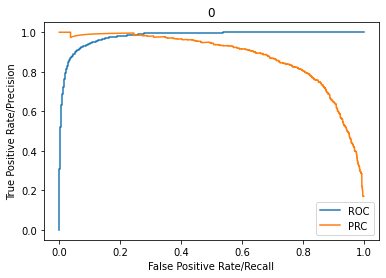

PRC AUC:0.8777411676786593
ROC AUC:0.9787473333333333


In [27]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt

probs = TrainedModel.predict_proba(X_t)
fpr1, tpr1, thresholds1 = roc_curve(Y_test[:,0], probs[:,0])
prec1, recall1, thresholds1 = precision_recall_curve(Y_test[:,0], probs[:,0])

plt.plot(fpr1,tpr1,label="ROC")
plt.plot(recall1,prec1,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('0')
plt.show()

print("PRC AUC:" + str(auc(recall1, prec1)))
print("ROC AUC:" + str(auc(fpr1, tpr1)))

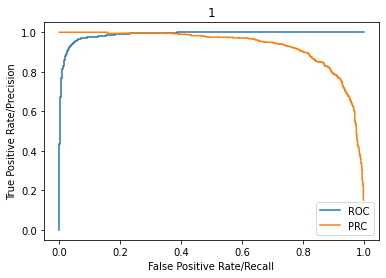

PRC AUC:0.930856302983288
ROC AUC:0.9883285555555555


In [28]:
fpr2, tpr2, thresholds2 = roc_curve(Y_test[:,1], probs[:, 1])
prec2, recall2, thresholds2 = precision_recall_curve(Y_test[:,1], probs[:, 1])

plt.plot(fpr2,tpr2,label="ROC")
plt.plot(recall2,prec2,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('1')
plt.show()

print("PRC AUC:" + str(auc(recall2, prec2)))
print("ROC AUC:" + str(auc(fpr2, tpr2)))

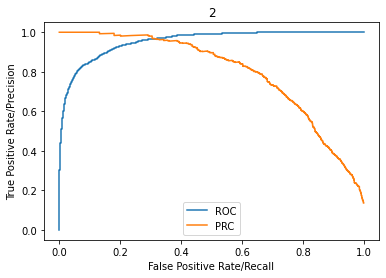

PRC AUC:0.796594213756778
ROC AUC:0.9531603333333333


In [29]:
fpr3, tpr3, thresholds3 = roc_curve(Y_test[:,2], probs[:, 2])
prec3, recall3, thresholds3 = precision_recall_curve(Y_test[:,2], probs[:, 2])

plt.plot(fpr3,tpr3,label="ROC")
plt.plot(recall3,prec3,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('2')
plt.show()

print("PRC AUC:" + str(auc(recall3, prec3)))
print("ROC AUC:" + str(auc(fpr3, tpr3)))

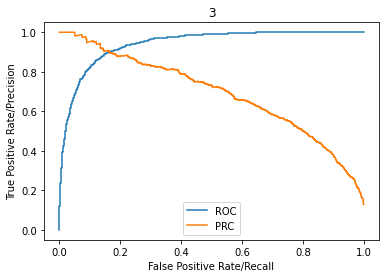

PRC AUC:0.6925203210440177
ROC AUC:0.9405506666666668


In [30]:
fpr4, tpr4, thresholds4 = roc_curve(Y_test[:,3], probs[:, 3])
prec4, recall4, thresholds4 = precision_recall_curve(Y_test[:,3], probs[:, 3])

plt.plot(fpr4,tpr4,label="ROC")
plt.plot(recall4,prec4,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('3')
plt.show()

print("PRC AUC:" + str(auc(recall4, prec4)))
print("ROC AUC:" + str(auc(fpr4, tpr4)))

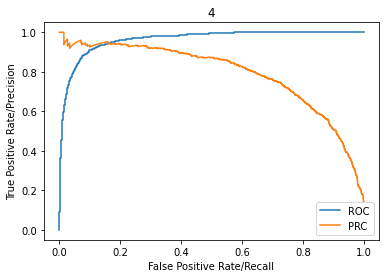

PRC AUC:0.7926706242104
ROC AUC:0.9632195555555556


In [31]:
fpr5, tpr5, thresholds5 = roc_curve(Y_test[:,4], probs[:, 4])
prec5, recall5, thresholds5 = precision_recall_curve(Y_test[:,4], probs[:, 4])

plt.plot(fpr5,tpr5,label="ROC")
plt.plot(recall5,prec5,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('4')
plt.show()

print("PRC AUC:" + str(auc(recall5, prec5)))
print("ROC AUC:" + str(auc(fpr5, tpr5)))

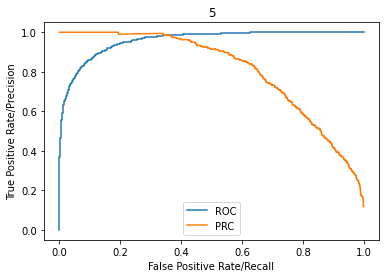

PRC AUC:0.8099270749833543
ROC AUC:0.9575101111111111


In [32]:
fpr6, tpr6, thresholds6 = roc_curve(Y_test[:,5], probs[:, 5])
prec6, recall6, thresholds6 = precision_recall_curve(Y_test[:,5], probs[:, 5])

plt.plot(fpr6,tpr6,label="ROC")
plt.plot(recall6,prec6,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('5')
plt.show()

print("PRC AUC:" + str(auc(recall6, prec6)))
print("ROC AUC:" + str(auc(fpr6, tpr6)))

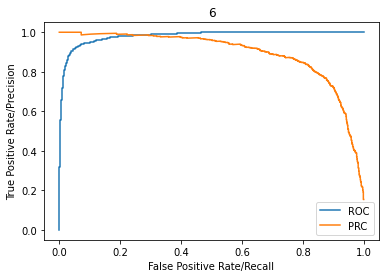

PRC AUC:0.8942192537345096
ROC AUC:0.9806527777777777


In [33]:
fpr7, tpr7, thresholds7 = roc_curve(Y_test[:,6], probs[:, 6])
prec7, recall7, thresholds7 = precision_recall_curve(Y_test[:,6], probs[:, 6])

plt.plot(fpr7,tpr7,label="ROC")
plt.plot(recall7,prec7,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('6')
plt.show()

print("PRC AUC:" + str(auc(recall7, prec7)))
print("ROC AUC:" + str(auc(fpr7, tpr7)))

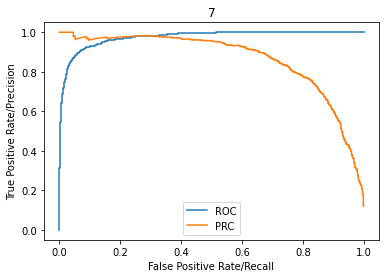

PRC AUC:0.8658318667370799
ROC AUC:0.9738423333333334


In [34]:
fpr8, tpr8, thresholds8 = roc_curve(Y_test[:,7], probs[:, 7])
prec8, recall8, thresholds8 = precision_recall_curve(Y_test[:,7], probs[:, 7])

plt.plot(fpr8,tpr8,label="ROC")
plt.plot(recall8,prec8,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('7')
plt.show()

print("PRC AUC:" + str(auc(recall8, prec8)))
print("ROC AUC:" + str(auc(fpr8, tpr8)))

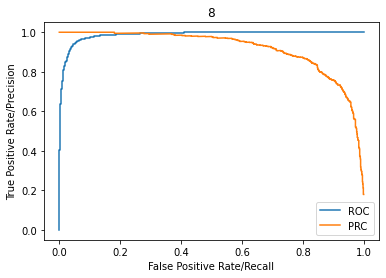

PRC AUC:0.9181476746165099
ROC AUC:0.9868296666666667


In [35]:
fpr9, tpr9, thresholds9 = roc_curve(Y_test[:,8], probs[:, 8])
prec9, recall9, thresholds9 = precision_recall_curve(Y_test[:,8], probs[:, 8])

plt.plot(fpr9,tpr9,label="ROC")
plt.plot(recall9,prec9,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('8')
plt.show()

print("PRC AUC:" + str(auc(recall9, prec9)))
print("ROC AUC:" + str(auc(fpr9, tpr9)))

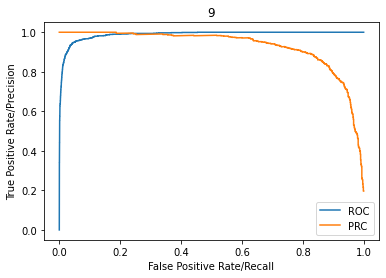

PRC AUC:0.9296667902450042
ROC AUC:0.9882901666666667


In [36]:
fpr10, tpr10, thresholds10 = roc_curve(Y_test[:,9], probs[:, 9])
prec10, recall10, thresholds10 = precision_recall_curve(Y_test[:,9], probs[:, 9])

plt.plot(fpr10,tpr10,label="ROC")
plt.plot(recall10,prec10,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('9')
plt.show()

print("PRC AUC:" + str(auc(recall10, prec10)))
print("ROC AUC:" + str(auc(fpr10, tpr10)))